In [1]:
import numpy as np

volume_train = np.load(r'./NYC-stdn/volume_train.npz')['volume']
volume_test = np.load(r'./NYC-stdn/volume_test.npz')['volume']

check dataset

In [2]:
for v in [volume_train, volume_test]:
    is_nan = np.isnan(v).any()
    print(is_nan)

False
False


In [3]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
print(torch.version.cuda)

cuda:0
1.13.1
11.6


In [4]:
from torch import nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [5]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.sequence = nn.Sequential(
            conv3x3(1, 64),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            conv3x3(64, 64),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),

            conv3x3(64, 128, 2),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            conv3x3(128, 128),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),

            conv3x3(128, 256, 2),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            conv3x3(256, 256),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),

            conv3x3(256, 512, 2),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),

            nn.Flatten(),
            nn.Linear(2*3*512, 1024),
            nn.ELU(True),
            nn.Linear(1024, 6)
        )

    def forward(self, x):
        x = self.sequence(x)
        return x

In [6]:
class TransConv(nn.Module):
    def __init__(self):
        super(TransConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ELU(True),
            nn.BatchNorm2d(64),

            conv3x3(64, 64),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            conv3x3(64, 64),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),

            conv1x1(64, 1),
            nn.BatchNorm2d(1),
            nn.ELU(inplace=True),
            conv1x1(1, 1),
            nn.BatchNorm2d(1),
            nn.ELU(inplace=True),
        )

    def forward(self, x):
        x = self.sequence(x)
        return x

In [7]:
class MyModel(nn.Module):
    def __init__(self, _conv, transconv):
        super(MyModel, self).__init__()
        self.conv = _conv
        self.lstm = nn.LSTM(input_size=6, hidden_size=128, batch_first=True)
        self.output = nn.Linear(128, 50)
        self.Tconv = transconv

    def forward(self, x):
        x = x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3], x.shape[4])
        x = self.conv(x)
        x = x.reshape(-1, 6, 6)
        _, out_tpl = self.lstm(x)
        x = self.output(out_tpl[0][0, :, :])
        x = x.reshape(-1, 5, 10)
        x = self.Tconv(x.unsqueeze(1))
        return x

In [8]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, item):
        return self.X[item], self.y[item]

    def __len__(self):
        return self.X.shape[0]

In [9]:
class MakeDataset:
    def __init__(self, data_pth):
        self.raw_data = np.load(data_pth)['volume'][:, :, :, 0]
        # normalize
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, window_size=7):
        seqs, labels = [], []
        for i in range(self.data.shape[0]):
            seqs.append(self.data[i:i + window_size - 1])
            labels.append(self.data[i + window_size - 1])
            if i + window_size >= self.data.shape[0]:
                break

        dataset = MyDataset(torch.Tensor(np.array(seqs)).unsqueeze(2), torch.Tensor(np.array(labels)))
        return dataset

In [10]:
from sklearn.model_selection import KFold

train_dataset = MakeDataset(r'./NYC-stdn/volume_train.npz')
train_set = list(train_dataset.construct_set())
test_dataset = MakeDataset(r'./NYC-stdn/volume_test.npz')
test_set = test_dataset.construct_set()

kf = KFold(n_splits=5)
train_lst, val_lst = [], []
for train_idx, val_idx in kf.split(train_set):
    # val_idx fall on either side of train_idx
    if train_idx[0] > val_idx[-1] or val_idx[0] > train_idx[-1]:
        train_lst.append(train_set[train_idx[0]:train_idx[-1]+1])
    else: # train_idx are cut-off by val_idx
        train_lst.append(train_set[train_idx[0]:val_idx[0]]+train_set[val_idx[-1]+1:])
    val_lst.append(train_set[val_idx[0]:val_idx[-1]+1])

In [11]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=True, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: True
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # Saves model when validation loss decrease.
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
from sklearn.metrics import mean_absolute_error as mae_fn, mean_squared_error as mse_fn


def compute_metrics(targets, predictions):
    mae = mae_fn(targets, predictions)
    rmse = np.sqrt(mse_fn(targets, predictions))
    return mae, rmse

In [13]:
def test(net, test_iter, device, loss_fn, denormalize_fn=test_dataset.denormalize):
    net.eval()
    _test_loss = 0.0
    output_lst, label_lst = [], []
    for inputs, labels in test_iter:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs.squeeze(1), labels)
        _test_loss += loss.item()

        output_lst.append(outputs.detach().cpu().numpy())
        label_lst.append(labels.detach().cpu().numpy())

    predict_value = denormalize_fn(np.concatenate(output_lst))
    true_value = denormalize_fn(np.concatenate(label_lst))

    return _test_loss, true_value, predict_value

In [14]:
from datetime import datetime
import time


def train(epochs, net, train_iter, val_iter, test_iter, device, loss_fn, optimizer, denormalize_fn):
    net_pth = f'./weights/checpoint_{datetime.now().strftime("%d-%H.%M.%S")}.pt'
    early_stopping = EarlyStopping(50, path=net_pth)
    for epoch in range(epochs):
        net.train()
        train_loss = 0.0
        output_lst, label_lst = [], []
        for inputs, labels in train_iter:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = loss_fn(outputs.squeeze(1), labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            output_lst.append(outputs.detach().cpu().numpy())
            label_lst.append(labels.detach().cpu().numpy())

        predict_value = denormalize_fn(np.concatenate(output_lst))
        true_value = denormalize_fn(np.concatenate(label_lst))
        train_mae, train_rmse = compute_metrics(true_value.reshape(-1, 200), 
                                                predict_value.reshape(-1, 200))
        train_metric_lst = [train_loss, train_mae, train_rmse]

        for i in range(len(train_metric_lst)):
            train_metric_total[i].append(train_metric_lst[i])

        if epoch % 5 == 0:
            print(f'epoch: {epoch:02d}, train -> loss: {train_loss:.4f}, '
                  f'mae: {train_mae:.3f}, rmse: {train_rmse:.3f}')

        val_loss, targets, predictions = test(net, val_iter, device, loss_fn, denormalize_fn)
        val_mae, val_rmse = compute_metrics(targets.reshape(-1, 200), predictions.reshape(-1, 200))
        val_metric_lst = [val_loss, val_mae, val_rmse]

        for i in range(len(val_metric_lst)):
            val_metric_total[i].append(val_metric_lst[i])

        if epoch % 5 == 0:
            print(' '*10, f'val -> loss: {val_loss:.4f}, '
                          f'mae: {val_mae:.3f}, rmse: {val_rmse:.3f}')

        early_stopping(val_mae, net)
        if early_stopping.early_stop:
            print("early stopping.")
            break

    weights = torch.load(net_pth)
    net.load_state_dict(weights)
    test_loss, targets, predictions = test(net, test_iter, device, loss_fn)
    test_mae, test_rmse = compute_metrics(targets.reshape(-1, 200), predictions.reshape(-1, 200))

    print(f'test -> loss: {test_loss:.4f}, '
          f'mae: {test_mae:.3f}, rmse: {test_rmse:.3f}')

    test_metric_lst = [test_loss, test_mae, test_rmse]
    for i in range(len(test_metric_lst)):
        test_metric_total[i].append(test_metric_lst[i])

In [15]:
from torch.utils.data import DataLoader
from torch import optim

BATCH_SIZE = 64
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False)

loss_fn = nn.MSELoss().to(device)
LEARNING_RATE = 1e-3
EPOCHS = 200

In [16]:
start_time = time.time()
train_loss_lst, train_rmse_lst, train_mae_lst = [], [], []
train_metric_total = [train_loss_lst, train_mae_lst, train_rmse_lst]
val_loss_lst, val_rmse_lst, val_mae_lst = [], [], []
val_metric_total = [val_loss_lst, val_mae_lst, val_rmse_lst]
test_loss_lst, test_rmse_lst, test_mae_lst = [], [], []
test_metric_total = [test_loss_lst, test_mae_lst, test_rmse_lst]
for itr in range(5):
    train_loader = DataLoader(train_lst[itr], batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_lst[itr], batch_size=BATCH_SIZE, shuffle=False)
    conv, Tconv = Conv(), TransConv()
    model = MyModel(conv, Tconv).to(device)
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    train(EPOCHS, model, train_loader, val_loader, test_loader,
          device, loss_fn, optimizer, train_dataset.denormalize)

end_time = time.time()
duration = end_time - start_time
if duration >= 60:
    print('\ntime using {} --> {:.3} min'.format(device, duration / 60))
else:
    print('\ntime using {} --> {:.3} s'.format(device, duration))

epoch: 00, train -> loss: 9.5255, mae: 604.545, rmse: 724.345
           val -> loss: 0.2620, mae: 233.532, rmse: 240.074
Validation loss decreased (inf --> 233.531921).  Saving model ...
Validation loss decreased (233.531921 --> 231.593948).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
Validation loss decreased (231.593948 --> 115.851524).  Saving model ...
epoch: 05, train -> loss: 0.5199, mae: 82.285, rmse: 169.147
           val -> loss: 0.0674, mae: 63.427, rmse: 121.805
Validation loss decreased (115.851524 --> 63.426601).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
epoch: 10, train -> loss: 0.3905, mae: 64.956, rmse: 146.552
           val -> loss: 0.0631, mae: 49.377, rmse: 117.945
Validation loss decreased (63.426601 --> 49.376976).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (49.376976 -

In [17]:
from matplotlib import pyplot as plt


def draw_metrics(y1, y2, label_0, label_1, loc, x_num):
    x = list(range(x_num))
    plt.plot(x, y1, label=label_0, c='#5F4393', linewidth=2)
    plt.plot(x, y2, label=label_1, c='#00ACC1', linestyle=(0, (3.6, 0.8)), linewidth=2)
    plt.legend(loc=loc, fontsize=12, framealpha=0.9)
    plt.grid(color='grey', linestyle='--')
    plt.xlabel('Epoch', fontdict={'fontsize': 12})
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

In [18]:
from matplotlib import ticker


def plot_metrics(_train_metrics, _val_metrics):
    len_ = len(_train_metrics[0])
    plt.figure(figsize=(10.24, 7.68))
    plt.subplot(2, 2, 1)
    draw_metrics(_train_metrics[0], _val_metrics[0], 'Train Loss', 'Val Loss', 'upper right', len_)
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    label_lst = ['MAE', 'RMSE']
    for i in range(3, 5):
        plt.subplot(2, 2, i)
        draw_metrics(_train_metrics[i-2], _val_metrics[i-2], 'Train ' + label_lst[i-3], 
                     'Val ' + label_lst[i-3], 'upper right', len_)
        plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

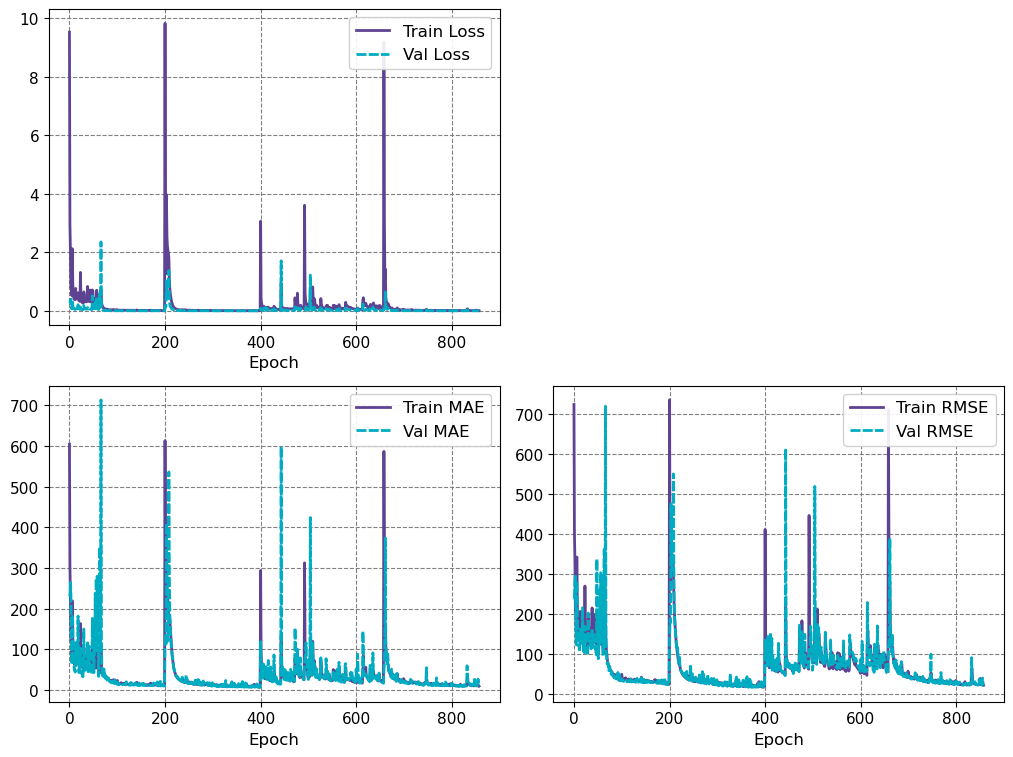

In [19]:
plot_metrics(train_metric_total, val_metric_total)

In [20]:
import pandas as pd

df = pd.DataFrame({'test_mae': test_metric_total[1], 'test_rmse': test_metric_total[2], 
                   'mae_avg': np.nan, 'mae_std': np.nan,
                   'rmse_avg': np.nan, 'rmse_std': np.nan})
df.loc[0, 'mae_avg'] = np.mean(test_metric_total[1])
df.loc[0, 'mae_std'] = np.std(test_metric_total[1])
df.loc[0, 'rmse_avg'] = np.mean(test_metric_total[2])
df.loc[0, 'rmse_std'] = np.std(test_metric_total[2])
df

,test_mae,test_rmse,mae_avg,mae_std,rmse_avg,rmse_std
0,10.380930,23.581976,11.000655,3.394826,30.136005,12.533582
1,6.560760,16.422638,NaN,NaN,NaN,NaN
2,14.001659,46.072182,NaN,NaN,NaN,NaN
3,15.663319,44.366024,NaN,NaN,NaN,NaN
4,8.396610,20.237194,NaN,NaN,NaN,NaN
